In [89]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [90]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [91]:
NUM_CLASSES = 14

# 学習データ読み込み

In [92]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [93]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [95]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [96]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 14)                154       
                                                                 
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


In [97]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [98]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [99]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
54/56 [===========================>..] - ETA: 0s - loss: 2.5725 - accuracy: 0.1503
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
56/56 [==============================] - 1s 10ms/step - loss: 2.5686 - accuracy: 0.1509 - val_loss: 2.4281 - val_accuracy: 0.2100
Epoch 2/1000
46/56 [=======================>......] - ETA: 0s - loss: 2.4258 - accuracy: 0.1941
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
56/56 [==============================] - 0s 4ms/step - loss: 2.4162 - accuracy: 0.1924 - val_loss: 2.2688 - val_accuracy: 0.2490
Epoch 3/1000
45/56 [=======================>......] - ETA: 0s - loss: 2.2948 - accuracy: 0.2311
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
56/56 [==============================] - 0s 6ms/step - loss: 2.2877 - accuracy: 0.2349 - val_loss: 2.1232 - val_accuracy: 0.3504
Epoch 4/1000
56/56 [==============================] - ETA: 0s - loss: 2.1832 - accuracy: 0.2589


In [100]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.8701


In [101]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [102]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 51ms/step
[5.4198974e-03 1.6317284e-02 3.5888474e-02 1.8674790e-04 1.5932797e-03
 3.7123638e-04 3.5871083e-01 5.7304573e-01 1.1705292e-04 2.3284512e-05
 3.3012938e-04 4.3543540e-03 1.5975497e-04 3.4819250e-03]
7


# 混同行列

75/75 [==============================] - 0s 1ms/step


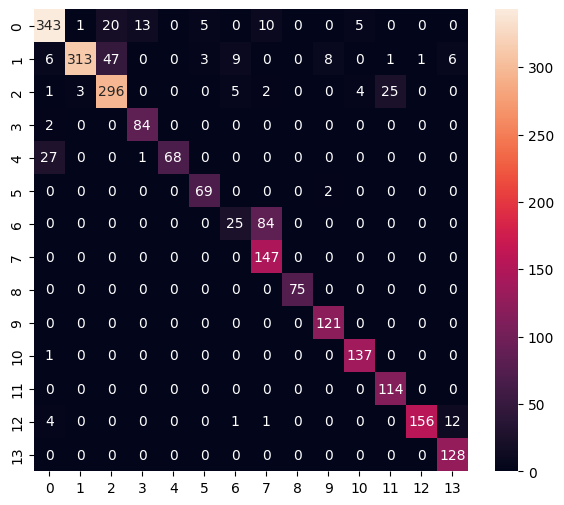

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       397
           1       0.99      0.79      0.88       394
           2       0.82      0.88      0.85       336
           3       0.86      0.98      0.91        86
           4       1.00      0.71      0.83        96
           5       0.90      0.97      0.93        71
           6       0.62      0.23      0.34       109
           7       0.60      1.00      0.75       147
           8       1.00      1.00      1.00        75
           9       0.92      1.00      0.96       121
          10       0.94      0.99      0.96       138
          11       0.81      1.00      0.90       114
          12       0.99      0.90      0.94       174
          13       0.88      1.00      0.93       128

    accuracy                           0.87      2386
   macro avg       0.87      0.88      0.86      2386
weighted avg       0.88      0.87      0.86      2386



In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [104]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [105]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmpvvu_2d3h\assets


INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmpvvu_2d3h\assets


7048

# 推論テスト

In [106]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [107]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [108]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [109]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.01 ms


In [110]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[5.4198969e-03 1.6317287e-02 3.5888467e-02 1.8674810e-04 1.5932797e-03
 3.7123659e-04 3.5871083e-01 5.7304573e-01 1.1705302e-04 2.3284538e-05
 3.3012952e-04 4.3543559e-03 1.5975496e-04 3.4819252e-03]
7
